In [1]:
# Libraries import
from datetime import datetime
from plotly.offline import init_notebook_mode
from googletrans import Translator

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombia GeoJson'
geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#geojson

In [5]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
status_counts = data['Estado'].value_counts().to_list()
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [6]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [10]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Casos activos VS Departamento (Estado)

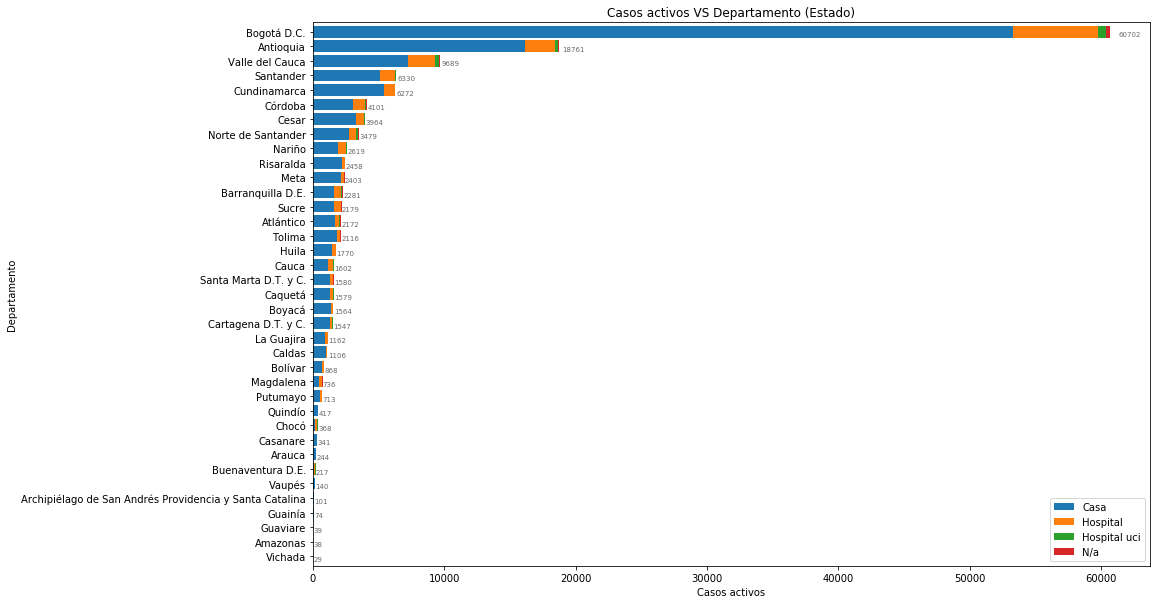

In [11]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos activos VS Departamento (Estado)'))
ax.set_xlabel('Casos activos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [12]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         53297.0    6495.0   
Antioquia                                           16167.0    2291.0   
Valle del Cauca                                      7263.0    2026.0   
Santander                                            5071.0    1168.0   
Cundinamarca                                         5435.0     782.0   
Córdoba                                              3043.0     899.0   
Cesar                                                3256.0     633.0   
Norte de Santander                                   2780.0     533.0   
Nariño                                               1899.0     641.0   
Risaralda                                            2230.0     206.0   
Meta                                                 2160.0     211.0   
Barranquilla D.E.                                    1624.0     506.0   
Sucre                                                1610.0     523.0   
Atlántico                                            1650.0     369.0   
Tolima                                               1801.0     265.0   
Huila                                                1457.0     294.0   
Cauca                                                1174.0     360.0   
Santa Marta D.T. y C.                                1290.0     257.0   
Caquetá                                              1286.0     271.0   
Boyacá                                               1384.0     154.0   
Cartagena D.T. y C.                                  1273.0     196.0   
La Guajira                                            890.0     237.0   
Caldas                                                964.0     118.0   
Bolívar                                               689.0     135.0   
Magdalena                                             470.0     204.0   
Putumayo                                              501.0     198.0   
Quindío                                               384.0      30.0   
Chocó                                                 192.0     146.0   
Casanare                                              289.0      45.0   
Arauca                                                217.0      24.0   
Buenaventura D.E.                                      94.0      99.0   
Vaupés                                                134.0       6.0   
Archipiélago de San Andrés Providencia y Santa ...     91.0       9.0   
Guainía                                                73.0       1.0   
Guaviare                                               35.0       3.0   
Amazonas                                               26.0       7.0   
Vichada                                                28.0       1.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                601.0  309.0   
Antioquia                                                  205.0   98.0   
Valle del Cauca                                            296.0  104.0   
Santander                                                   68.0   23.0   
Cundinamarca                                                26.0   29.0   
Córdoba                                                     80.0   79.0   
Cesar                                                       58.0   17.0   
Norte de Santander                                         148.0   18.0   
Nariño                                                      51.0   28.0   
Risaralda                                                   13.0    9.0   
Meta                                                        16.0   16.0   
Barranquilla D.E.                                           52.0   99.0   
Sucre                                                       23.0   23.0   
Atlántico                  

### - Recuperados VS Departamento

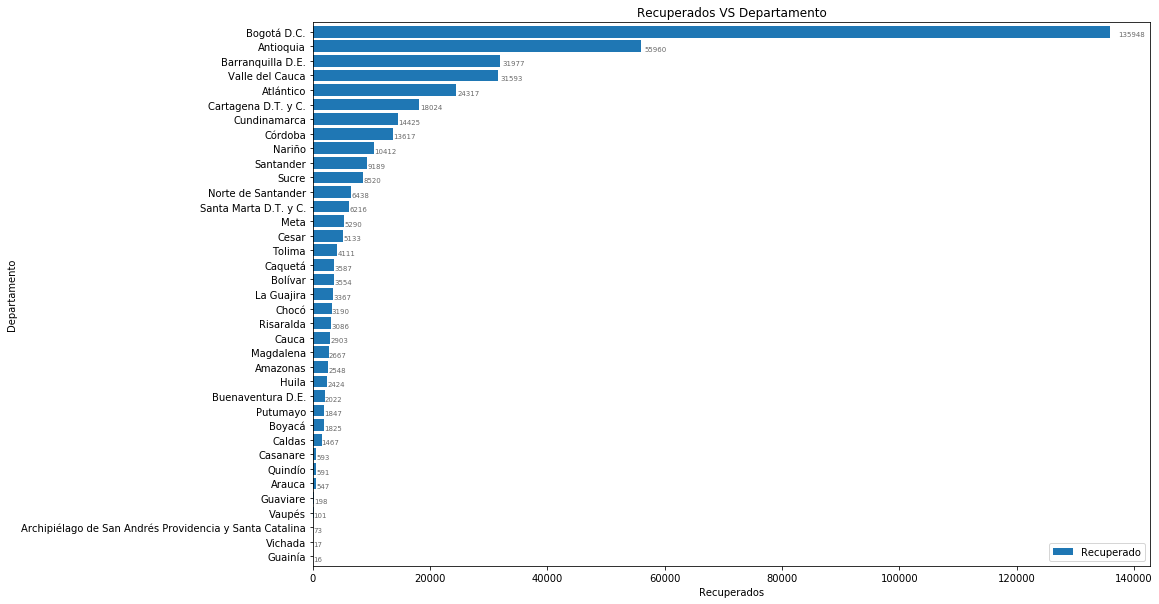

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, False, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Recuperados VS Departamento'))
ax.set_xlabel('Recuperados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                              Recuperado     Total
Departamento                                                            
Bogotá D.C.                                           135948.0  135948.0
Antioquia                                              55960.0   55960.0
Barranquilla D.E.                                      31977.0   31977.0
Valle del Cauca                                        31593.0   31593.0
Atlántico                                              24317.0   24317.0
Cartagena D.T. y C.                                    18024.0   18024.0
Cundinamarca                                           14425.0   14425.0
Córdoba                                                13617.0   13617.0
Nariño                                                 10412.0   10412.0
Santander                                               9189.0    9189.0
Sucre                                                   8520.0    8520.0
Norte de Santander                                      6438.0    6438.0
Santa Marta D.T. y C.                                   6216.0    6216.0
Meta                                                    5290.0    5290.0
Cesar                                                   5133.0    5133.0
Tolima                                                  4111.0    4111.0
Caquetá                                                 3587.0    3587.0
Bolívar                                                 3554.0    3554.0
La Guajira                                              3367.0    3367.0
Chocó                                                   3190.0    3190.0
Risaralda                                               3086.0    3086.0
Cauca                                                   2903.0    2903.0
Magdalena                                               2667.0    2667.0
Amazonas                                                2548.0    2548.0
Huila                                                   2424.0    2424.0
Buenaventura D.E.                                       2022.0    2022.0
Putumayo                                                1847.0    1847.0
Boyacá                                                  1825.0    1825.0
Caldas                                                  1467.0    1467.0
Casanare                                                 593.0     593.0
Quindío                                                  591.0     591.0
Arauca                                                   547.0     547.0
Guaviare                                                 198.0     198.0
Vaupés                                                   101.0     101.0
Archipiélago de San Andrés Providencia y Santa ...        73.0      73.0
Vichada                                                   17.0      17.0
Guainía                                                   16.0      16.0

### - Fallecidos VS Departamento

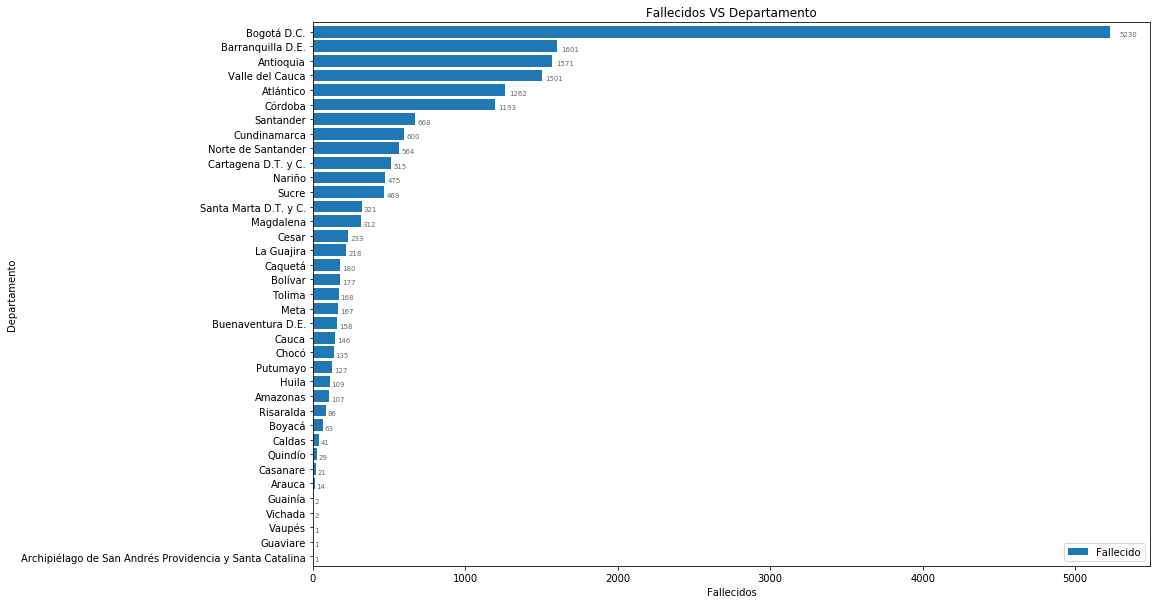

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Fallecidos VS Departamento'))
ax.set_xlabel('Fallecidos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [16]:
li.sort_values('Total', ascending=False)

Estado                                              Fallecido   Total
Departamento                                                         
Bogotá D.C.                                            5230.0  5230.0
Barranquilla D.E.                                      1601.0  1601.0
Antioquia                                              1571.0  1571.0
Valle del Cauca                                        1501.0  1501.0
Atlántico                                              1262.0  1262.0
Córdoba                                                1193.0  1193.0
Santander                                               668.0   668.0
Cundinamarca                                            600.0   600.0
Norte de Santander                                      564.0   564.0
Cartagena D.T. y C.                                     515.0   515.0
Nariño                                                  475.0   475.0
Sucre                                                   469.0   469.0
Santa Marta D.T. y C.                                   321.0   321.0
Magdalena                                               312.0   312.0
Cesar                                                   233.0   233.0
La Guajira                                              218.0   218.0
Caquetá                                                 180.0   180.0
Bolívar                                                 177.0   177.0
Tolima                                                  168.0   168.0
Meta                                                    167.0   167.0
Buenaventura D.E.                                       158.0   158.0
Cauca                                                   146.0   146.0
Chocó                                                   135.0   135.0
Putumayo                                                127.0   127.0
Huila                                                   109.0   109.0
Amazonas                                                107.0   107.0
Risaralda                                                86.0    86.0
Boyacá                                                   63.0    63.0
Caldas                                                   41.0    41.0
Quindío                                                  29.0    29.0
Casanare                                                 21.0    21.0
Arauca                                                   14.0    14.0
Guainía                                                   2.0     2.0
Vichada                                                   2.0     2.0
Guaviare                                                  1.0     1.0
Archipiélago de San Andrés Providencia y Santa ...        1.0     1.0
Vaupés                                                    1.0     1.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

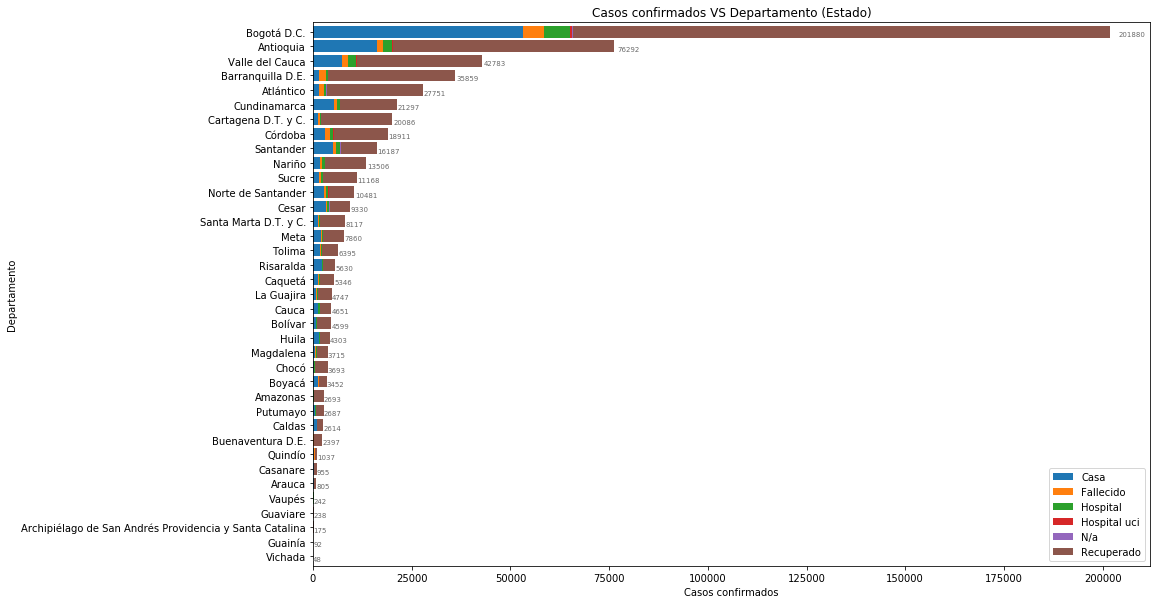

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         53297.0     5230.0   
Antioquia                                           16167.0     1571.0   
Valle del Cauca                                      7263.0     1501.0   
Barranquilla D.E.                                    1624.0     1601.0   
Atlántico                                            1650.0     1262.0   
Cundinamarca                                         5435.0      600.0   
Cartagena D.T. y C.                                  1273.0      515.0   
Córdoba                                              3043.0     1193.0   
Santander                                            5071.0      668.0   
Nariño                                               1899.0      475.0   
Sucre                                                1610.0      469.0   
Norte de Santander                                   2780.0      564.0   
Cesar                                                3256.0      233.0   
Santa Marta D.T. y C.                                1290.0      321.0   
Meta                                                 2160.0      167.0   
Tolima                                               1801.0      168.0   
Risaralda                                            2230.0       86.0   
Caquetá                                              1286.0      180.0   
La Guajira                                            890.0      218.0   
Cauca                                                1174.0      146.0   
Bolívar                                               689.0      177.0   
Huila                                                1457.0      109.0   
Magdalena                                             470.0      312.0   
Chocó                                                 192.0      135.0   
Boyacá                                               1384.0       63.0   
Amazonas                                               26.0      107.0   
Putumayo                                              501.0      127.0   
Caldas                                                964.0       41.0   
Buenaventura D.E.                                      94.0      158.0   
Quindío                                               384.0       29.0   
Casanare                                              289.0       21.0   
Arauca                                                217.0       14.0   
Vaupés                                                134.0        1.0   
Guaviare                                               35.0        1.0   
Archipiélago de San Andrés Providencia y Santa ...     91.0        1.0   
Guainía                                                73.0        2.0   
Vichada                                                28.0        2.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6495.0         601.0   
Antioquia                                             2291.0         205.0   
Valle del Cauca                                       2026.0         296.0   
Barranquilla D.E.                                      506.0          52.0   
Atlántico                                              369.0          62.0   
Cundinamarca                                           782.0          26.0   
Cartagena D.T. y C.                                    196.0          44.0   
Córdoba                                                899.0          80.0   
Santander                                             1168.0          68.0   
Nariño                                                 641.0          51.0   
Sucre                                                  523.0          23.0   
Norte de Santander                                     533.0         148.0   
Cesar                

### - Casos confirmados VS Departamento (Sexo)

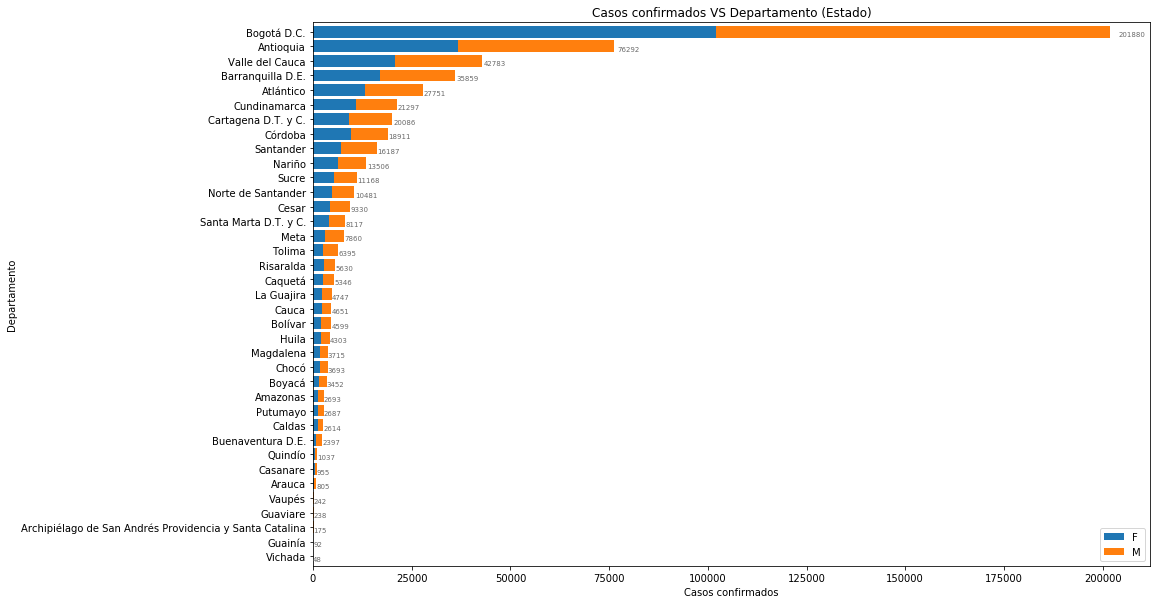

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                     F      M   Total
Departamento                                                             
Bogotá D.C.                                         102158  99722  201880
Antioquia                                            36673  39619   76292
Valle del Cauca                                      20699  22084   42783
Barranquilla D.E.                                    16902  18957   35859
Atlántico                                            13153  14598   27751
Cundinamarca                                         10798  10499   21297
Cartagena D.T. y C.                                   9239  10847   20086
Córdoba                                               9733   9178   18911
Santander                                             7029   9158   16187
Nariño                                                6470   7036   13506
Sucre                                                 5398   5770   11168
Norte de Santander                                    4832   5649   10481
Cesar                                                 4299   5031    9330
Santa Marta D.T. y C.                                 4083   4034    8117
Meta                                                  2926   4934    7860
Tolima                                                2517   3878    6395
Risaralda                                             2748   2882    5630
Caquetá                                               2637   2709    5346
La Guajira                                            2393   2354    4747
Cauca                                                 2169   2482    4651
Bolívar                                               2133   2466    4599
Huila                                                 2135   2168    4303
Magdalena                                             1882   1833    3715
Chocó                                                 1751   1942    3693
Boyacá                                                1587   1865    3452
Amazonas                                              1164   1529    2693
Putumayo                                              1211   1476    2687
Caldas                                                1246   1368    2614
Buenaventura D.E.                                      895   1502    2397
Quindío                                                518    519    1037
Casanare                                               397    558     955
Arauca                                                 259    546     805
Vaupés                                                 108    134     242
Guaviare                                                35    203     238
Archipiélago de San Andrés Providencia y Santa ...      99     76     175
Guainía                                                 39     53      92
Vichada                                                 13     35      48

### - Dataset COVID-19 (Colombia)

In [21]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
582058               2020-08-27           2020-08-25            2020-08-18   
582059               2020-08-27           2020-08-25            2020-08-18   
582060               2020-08-27           2020-08-25            2020-08-22   
582061               2020-08-27           2020-08-24            2020-08-22   
582062               2020-08-27           2020-08-25            2020-08-10   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
582058             2020-08-10 00:00:00                   NaT   
582059             2020-08-14 00:00:00                   NaT   
582060             2020-08-19 00:00:00                   NaT   
582061             2020-08-21 00:00:00                   NaT   
582062             2020-08-10 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
582058                    NaT          Bogotá d.c.      Bogotá D.C.      Leve   
582059                    NaT          Bogotá d.c.      Bogotá D.C.      Leve   
582060                    NaT          Bogotá d.c.      Bogotá D.C.      Leve   
582061                    NaT          Bogotá d.c.      Bogotá D.C.      Leve   
582062                    NaT          Bogotá d.c.      Bogotá D.C.      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
582058            Casa  ...                50 - 60    M               NaN   
582059            Casa  ...                60 - 70    M               NaN   
582060            Casa  ...                20 - 30    F               NaN   
582061            Casa  ...                30 - 40    F               NaN   
582062            Casa  ...                50 - 60    F               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Mapa de influencia COVID-19 (Colombia)

In [22]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

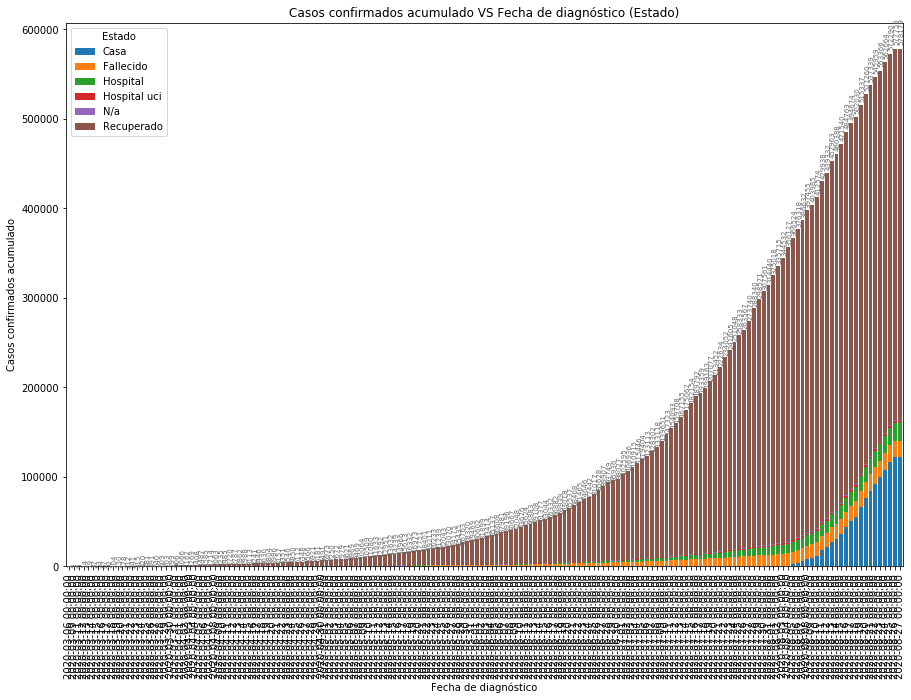

In [23]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [24]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-08-27            122221.0    18264.0   20257.0        1994.0  1161.0   
2020-08-26            121826.0    18264.0   20235.0        1987.0  1161.0   
2020-08-25            116938.0    18257.0   19741.0        1966.0  1161.0   
2020-08-24            107924.0    18204.0   19285.0        1965.0  1160.0   
2020-08-23             99269.0    18103.0   18839.0        1954.0  1154.0   
2020-08-22             92394.0    18032.0   18510.0        1952.0  1152.0   
2020-08-21             84628.0    17908.0   18037.0        1944.0  1147.0   
2020-08-20             75919.0    17768.0   17539.0        1900.0  1136.0   
2020-08-19             66214.0    17512.0   16831.0        1836.0  1126.0   
2020-08-18             55449.0    17317.0   16262.0        1815.0  1114.0   
2020-08-17             50089.0    17140.0   15871.0        1805.0  1097.0   
2020-08-16             44073.0    17008.0   15533.0        1793.0  1091.0   
2020-08-15             36063.0    16771.0   15071.0        1782.0  1084.0   
2020-08-14             30331.0    16536.0   14595.0        1765.0  1077.0   
2020-08-13             27438.0    16334.0   14274.0        1751.0  1069.0   
2020-08-12             21123.0    16073.0   13765.0        1732.0  1056.0   
2020-08-11             18104.0    15771.0   13298.0        1707.0  1047.0   
2020-08-10             11713.0    15400.0   12626.0        1648.0  1030.0   
2020-08-09              9676.0    15195.0   12283.0        1629.0  1013.0   
2020-08-08              8071.0    14989.0   11960.0        1608.0  1008.0   
2020-08-07              5606.0    14699.0   11650.0        1574.0   995.0   
2020-08-06              3987.0    14437.0   11308.0        1527.0   978.0   
2020-08-05              2245.0    14167.0   11011.0        1481.0   958.0   
2020-08-04               436.0    13894.0   10654.0        1436.0   937.0   
2020-08-03               245.0    13586.0   10322.0        1391.0   922.0   
2020-08-02               116.0    13267.0    9930.0        1354.0   905.0   
2020-08-01               103.0    12919.0    9521.0        1311.0   891.0   
2020-07-31                98.0    12587.0    9061.0        1277.0   871.0   
2020-07-30                94.0    12358.0    8804.0        1256.0   856.0   
2020-07-29                94.0    12074.0    8522.0        1212.0   836.0   
2020-07-28                90.0    11788.0    8186.0        1166.0   815.0   
2020-07-27                87.0    11248.0    7662.0        1109.0   781.0   
2020-07-26                80.0    10932.0    7354.0        1072.0   761.0   
2020-07-25                78.0    10695.0    7161.0        1047.0   749.0   
2020-07-24                77.0    10397.0    6842.0        1012.0   734.0   
2020-07-23                75.0    10100.0    6536.0         978.0   713.0   
2020-07-22                73.0     9731.0    6190.0         939.0   685.0   
2020-07-21                70.0     9292.0    5767.0         885.0   658.0   
2020-07-20                66.0     8949.0    5483.0         834.0   643.0   
2020-07-19                64.0     8680.0    5163.0         802.0   631.0   
2020-07-18                64.0     8404.0    4898.0         777.0   614.0   
2020-07-17                64.0     8167.0    4719.0         748.0   592.0   
2020-07-16                64.0     7993.0    4612.0         733.0   583.0   
2020-07-15                63.0     7711.0    4347.0         695.0   563.0   
2020-07-14                62.0     7417.0    4126.0         661.0   552.0   
2020-07-13                56.0     7133.0    3895.0         632.0   527.0   
2020-07-12                54.0     6867.0    3646.0         599.0   506.0   
2020-07-11                54.0     6655.0    3491.0         570.0   492.0   
2020-07-10                53.0     6396.0    3279.0         551.0   465.0   
2020-07-09                52.0     6177.0    3080.0         522.0   447.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

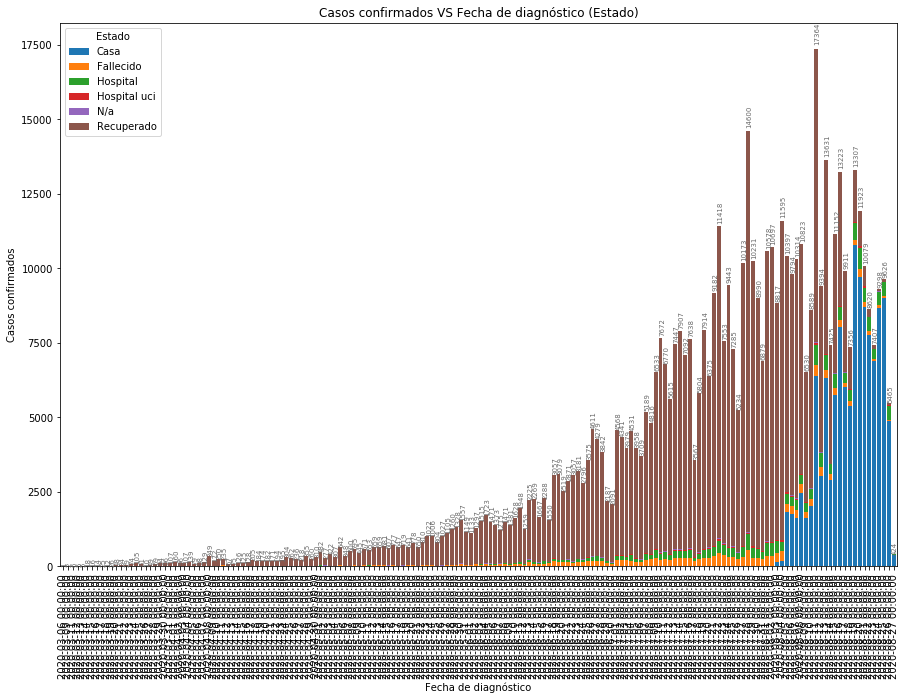

In [25]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [26]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                     
2020-08-27              395.0        0.0      22.0           7.0   0.0   
2020-08-26             4888.0        7.0     494.0          21.0   0.0   
2020-08-25             9014.0       53.0     456.0           1.0   1.0   
2020-08-24             8655.0      101.0     446.0          11.0   6.0   
2020-08-23             6875.0       71.0     329.0           2.0   2.0   
2020-08-22             7766.0      124.0     473.0           8.0   5.0   
2020-08-21             8709.0      140.0     498.0          44.0  11.0   
2020-08-20             9705.0      256.0     708.0          64.0  10.0   
2020-08-19            10765.0      195.0     569.0          21.0  12.0   
2020-08-18             5360.0      177.0     391.0          10.0  17.0   
2020-08-17             6016.0      132.0     338.0          12.0   6.0   
2020-08-16             8010.0      237.0     462.0          11.0   7.0   
2020-08-15             5732.0      235.0     476.0          17.0   7.0   
2020-08-14             2893.0      202.0     321.0          14.0   8.0   
2020-08-13             6315.0      261.0     509.0          19.0  13.0   
2020-08-12             3019.0      302.0     467.0          25.0   9.0   
2020-08-11             6391.0      371.0     672.0          59.0  17.0   
2020-08-10             2037.0      205.0     343.0          19.0  17.0   
2020-08-09             1605.0      206.0     323.0          21.0   5.0   
2020-08-08             2465.0      290.0     310.0          34.0  13.0   
2020-08-07             1619.0      262.0     342.0          47.0  17.0   
2020-08-06             1742.0      270.0     297.0          46.0  20.0   
2020-08-05             1809.0      273.0     357.0          45.0  21.0   
2020-08-04              191.0      308.0     332.0          45.0  15.0   
2020-08-03              129.0      319.0     392.0          37.0  17.0   
2020-08-02               13.0      348.0     409.0          43.0  14.0   
2020-08-01                5.0      332.0     460.0          34.0  20.0   
2020-07-31                4.0      229.0     257.0          21.0  15.0   
2020-07-30                0.0      284.0     282.0          44.0  20.0   
2020-07-29                4.0      286.0     336.0          46.0  21.0   
2020-07-28                3.0      540.0     524.0          57.0  34.0   
2020-07-27                7.0      316.0     308.0          37.0  20.0   
2020-07-26                2.0      237.0     193.0          25.0  12.0   
2020-07-25                1.0      298.0     319.0          35.0  15.0   
2020-07-24                2.0      297.0     306.0          34.0  21.0   
2020-07-23                2.0      369.0     346.0          39.0  28.0   
2020-07-22                3.0      439.0     423.0          54.0  27.0   
2020-07-21                4.0      343.0     284.0          51.0  15.0   
2020-07-20                2.0      269.0     320.0          32.0  12.0   
2020-07-19                0.0      276.0     265.0          25.0  17.0   
2020-07-18                0.0      237.0     179.0          29.0  22.0   
2020-07-17                0.0      174.0     107.0          15.0   9.0   
2020-07-16                1.0      282.0     265.0          38.0  20.0   
2020-07-15                1.0      294.0     221.0          34.0  11.0   
2020-07-14                6.0      284.0     231.0          29.0  25.0   
2020-07-13                2.0      266.0     249.0          33.0  21.0   
2020-07-12                0.0      212.0     155.0          29.0  14.0   
2020-07-11                1.0      259.0     212.0          19.0  27.0   
2020-07-10                1.0      219.0     199.0          29.0  18.0   
2020-07-09                0.0      293.0     250.0          43.0  10.0   
2020-07-08                1.0      241.0     147.0          24.0   9.0   
2020-07-07                1.0      212.0     198.0          28.0  18.0   
2020

### - Casos confirmados VS Clasificación de edad (Estado)

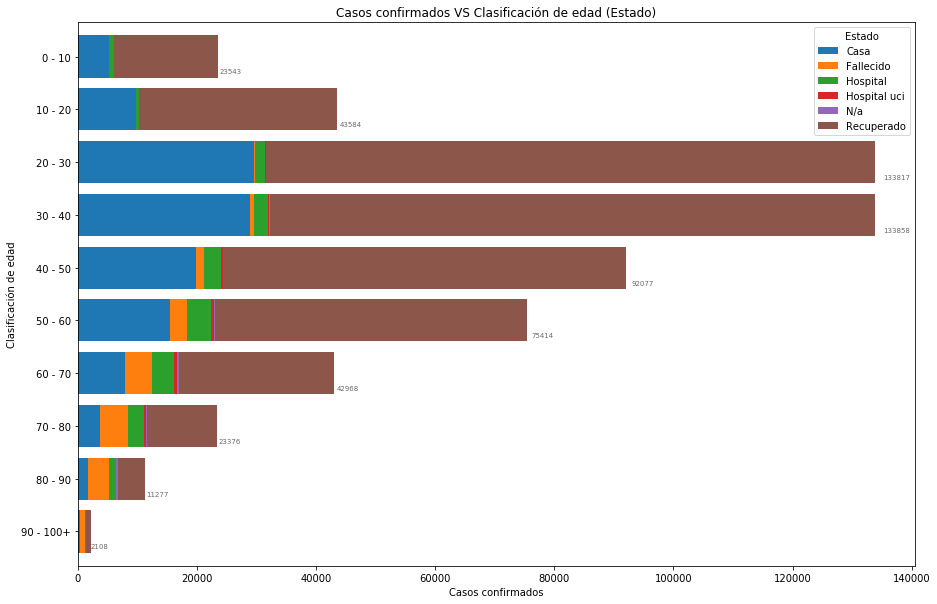

In [27]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [28]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  5202         29       803            41   28   
10 - 20                 9702         32       495            35   20   
20 - 30                29499        237      1687            90   53   
30 - 40                28935        604      2429           196   43   
40 - 50                19768       1348      2905           297   91   
50 - 60                15481       2795      4145           495  143   
60 - 70                 7896       4469      3844           469  241   
70 - 80                 3761       4692      2605           299  273   
80 - 90                 1669       3472      1236            77  233   
90 - 100+                314        790       194             8   59   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      17440  
10 - 20                     33300  
20 - 30                    102251  
30 - 40                    101651  
40 - 50                     67668  
50 - 60                     52355  
60 - 70                     26049  
70 - 80                     11746  
80 - 90                      4590  
90 - 100+                     743

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

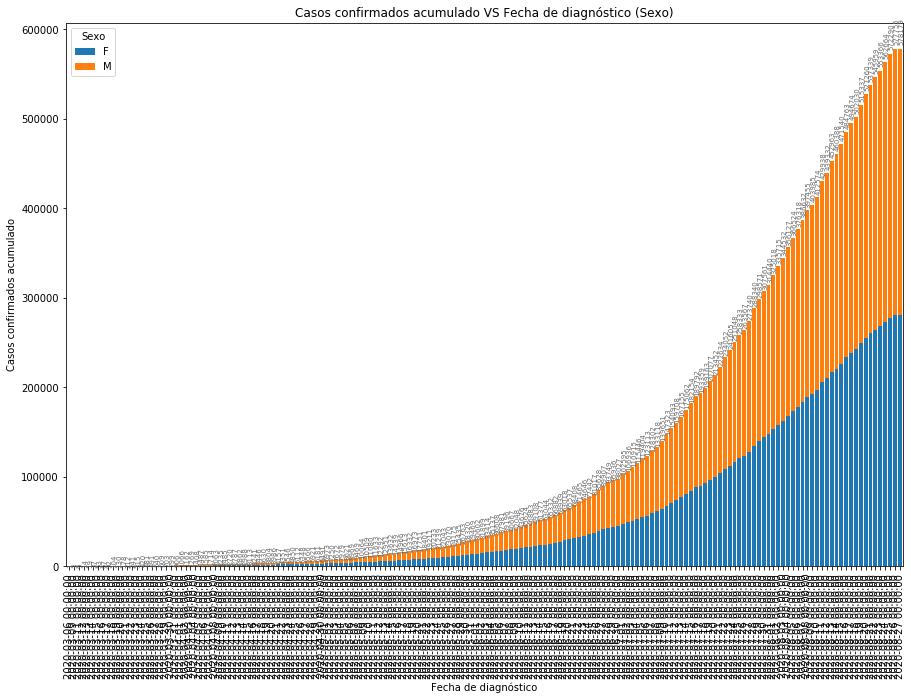

In [29]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [30]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-08-27            280510.0  297669.0
2020-08-26            280288.0  297467.0
2020-08-25            277495.0  294795.0
2020-08-24            272650.0  290014.0
2020-08-23            267985.0  285381.0
2020-08-22            264222.0  281737.0
2020-08-21            260154.0  277185.0
2020-08-20            255068.0  272192.0
2020-08-19            249056.0  266281.0
2020-08-18            242144.0  259886.0
2020-08-17            238583.0  256091.0
2020-08-16            233344.0  251419.0
2020-08-15            226433.0  245107.0
2020-08-14            220735.0  239653.0
2020-08-13            216935.0  236028.0
2020-08-12            210104.0  229228.0
2020-08-11            205453.0  224485.0
2020-08-10            196449.0  216125.0
2020-08-09            192140.0  211845.0
2020-08-08            188770.0  208685.0
2020-08-07            183500.0  203132.0
2020-08-06            178461.0  197857.0
2020-08-05            173611.0  192913.0
2020-08-04            168403.0  187724.0
2020-08-03            162591.0  181941.0
2020-08-02            158324.0  177391.0
2020-08-01            152854.0  172164.0
2020-07-31            147735.0  166705.0
2020-07-30            144286.0  163275.0
2020-07-29            139915.0  158656.0
2020-07-28            134838.0  153502.0
2020-07-27            127727.0  146013.0
2020-07-26            122852.0  140715.0
2020-07-25            120453.0  137880.0
2020-07-24            116765.0  134283.0
2020-07-23            112399.0  129206.0
2020-07-22            108830.0  125222.0
2020-07-21            103667.0  118967.0
2020-07-20             99365.0  114087.0
2020-07-19             96389.0  110688.0
2020-07-18             92599.0  106564.0
2020-07-17             89818.0  103541.0
2020-07-16             88061.0  101731.0
2020-07-15             84312.0   97842.0
2020-07-14             80943.0   94119.0
2020-07-13             77347.0   89808.0
2020-07-12             73778.0   85930.0
2020-07-11             71104.0   82989.0
2020-07-10             67889.0   79434.0
2020-07-09             64384.0   75267.0
2020-07-08             61419.0   71699.0
2020-07-07             59109.0   69193.0
2020-07-06             56700.0   66413.0
2020-07-05             54947.0   64457.0
2020-07-04             53113.0   62333.0
2020-07-03             51084.0   59831.0
2020-07-02             49228.0   57708.0
2020-07-01             47199.0   55396.0
2020-06-30             45124.0   52903.0
2020-06-29             44151.0   51785.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

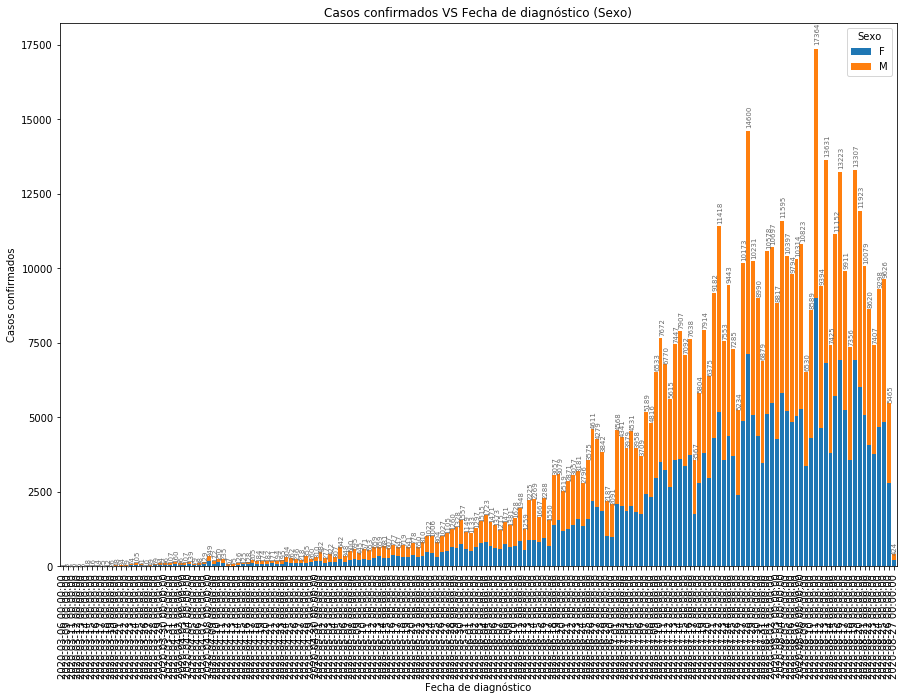

In [31]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [32]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-08-27             222.0   202.0
2020-08-26            2793.0  2672.0
2020-08-25            4845.0  4781.0
2020-08-24            4665.0  4633.0
2020-08-23            3763.0  3644.0
2020-08-22            4068.0  4552.0
2020-08-21            5086.0  4993.0
2020-08-20            6012.0  5911.0
2020-08-19            6912.0  6395.0
2020-08-18            3561.0  3795.0
2020-08-17            5239.0  4672.0
2020-08-16            6911.0  6312.0
2020-08-15            5698.0  5454.0
2020-08-14            3800.0  3625.0
2020-08-13            6831.0  6800.0
2020-08-12            4651.0  4743.0
2020-08-11            9004.0  8360.0
2020-08-10            4309.0  4280.0
2020-08-09            3370.0  3160.0
2020-08-08            5270.0  5553.0
2020-08-07            5039.0  5275.0
2020-08-06            4850.0  4944.0
2020-08-05            5208.0  5189.0
2020-08-04            5812.0  5783.0
2020-08-03            4267.0  4550.0
2020-08-02            5470.0  5227.0
2020-08-01            5119.0  5459.0
2020-07-31            3449.0  3430.0
2020-07-30            4371.0  4619.0
2020-07-29            5077.0  5154.0
2020-07-28            7111.0  7489.0
2020-07-27            4875.0  5298.0
2020-07-26            2399.0  2835.0
2020-07-25            3688.0  3597.0
2020-07-24            4366.0  5077.0
2020-07-23            3569.0  3984.0
2020-07-22            5163.0  6255.0
2020-07-21            4302.0  4880.0
2020-07-20            2976.0  3399.0
2020-07-19            3790.0  4124.0
2020-07-18            2781.0  3023.0
2020-07-17            1757.0  1810.0
2020-07-16            3749.0  3889.0
2020-07-15            3369.0  3723.0
2020-07-14            3596.0  4311.0
2020-07-13            3569.0  3878.0
2020-07-12            2674.0  2941.0
2020-07-11            3215.0  3555.0
2020-07-10            3505.0  4167.0
2020-07-09            2965.0  3568.0
2020-07-08            2310.0  2506.0
2020-07-07            2409.0  2780.0
2020-07-06            1753.0  1956.0
2020-07-05            1834.0  2124.0
2020-07-04            2029.0  2502.0
2020-07-03            1856.0  2123.0
2020-07-02            2029.0  2312.0
2020-07-01            2075.0  2493.0
2020-06-30             973.0  1118.0
2020-06-29            1001.0  1186.0

### - Casos confirmados VS Clasificación de edad (Sexo)

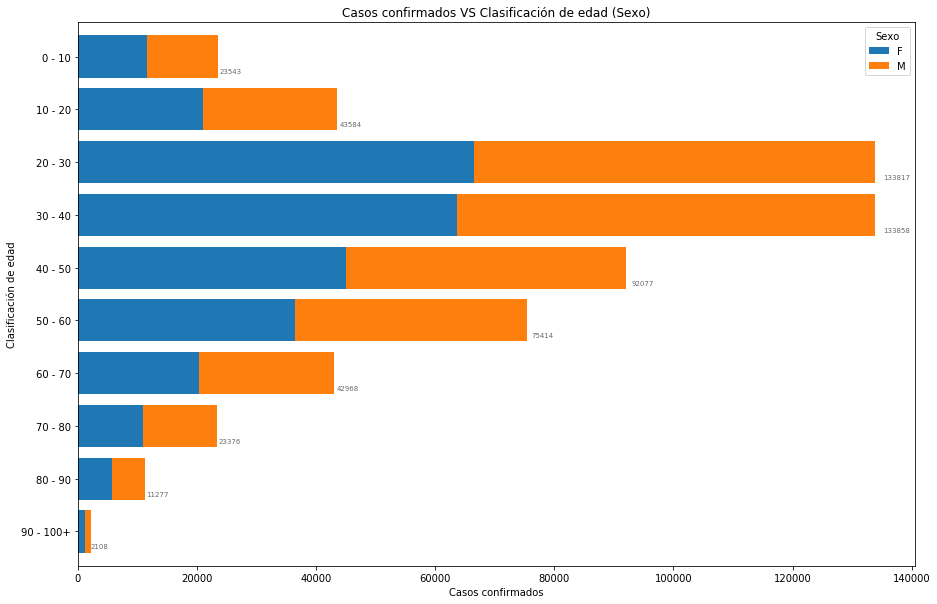

In [33]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [34]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 11540  12003
10 - 20                20948  22636
20 - 30                66556  67261
30 - 40                63663  70195
40 - 50                44971  47106
50 - 60                36461  38953
60 - 70                20360  22608
70 - 80                10899  12477
80 - 90                 5731   5546
90 - 100+               1199    909

### - Casos confirmados VS Estado (Sexo)

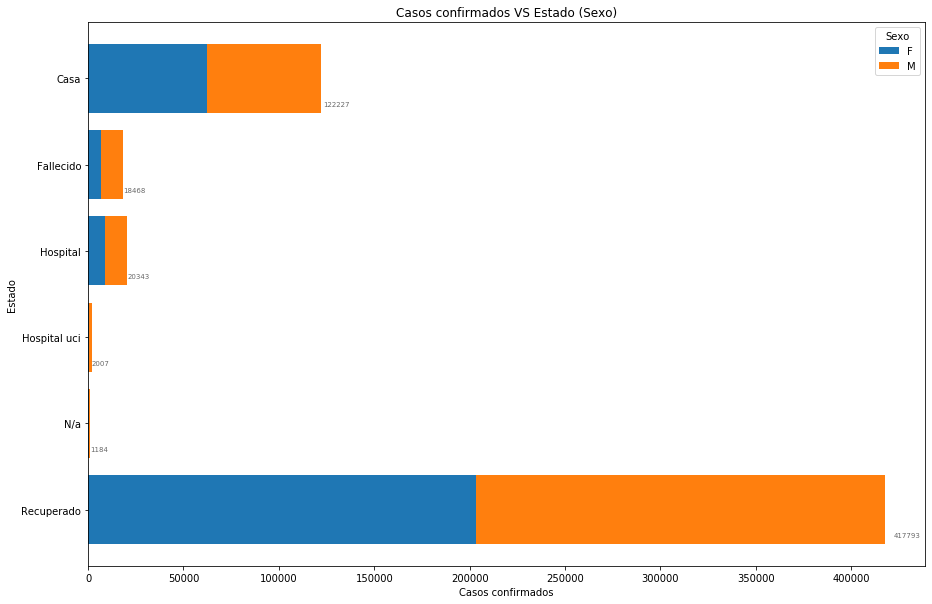

In [35]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [36]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           62414   59813
Fallecido       6604   11864
Hospital        8717   11626
Hospital uci     700    1307
N/a              510     674
Recuperado    203383  214410

### - Casos confirmados VS Tipo de contagio (Sexo)

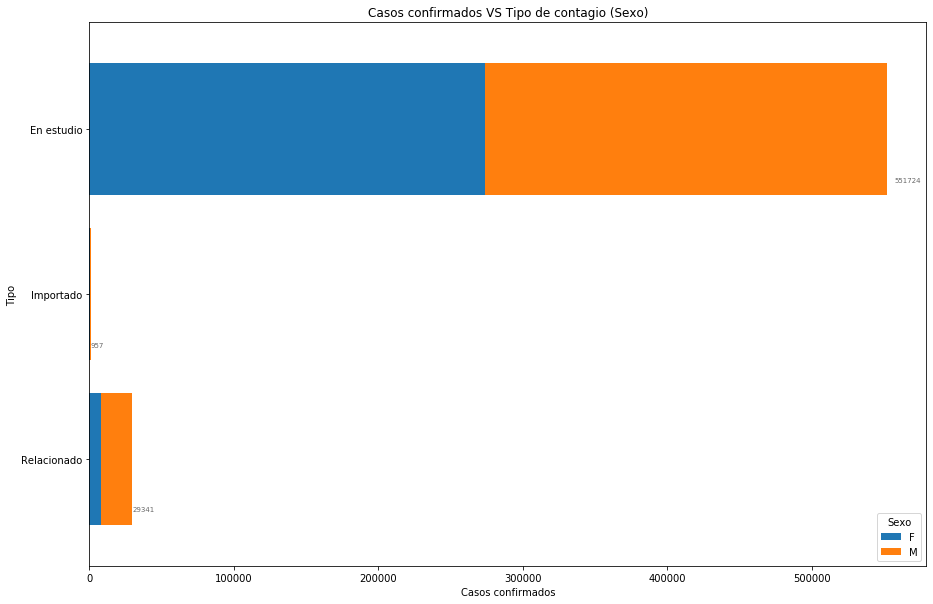

In [37]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [38]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   273854  277870
Importado       450     507
Relacionado    8024   21317

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

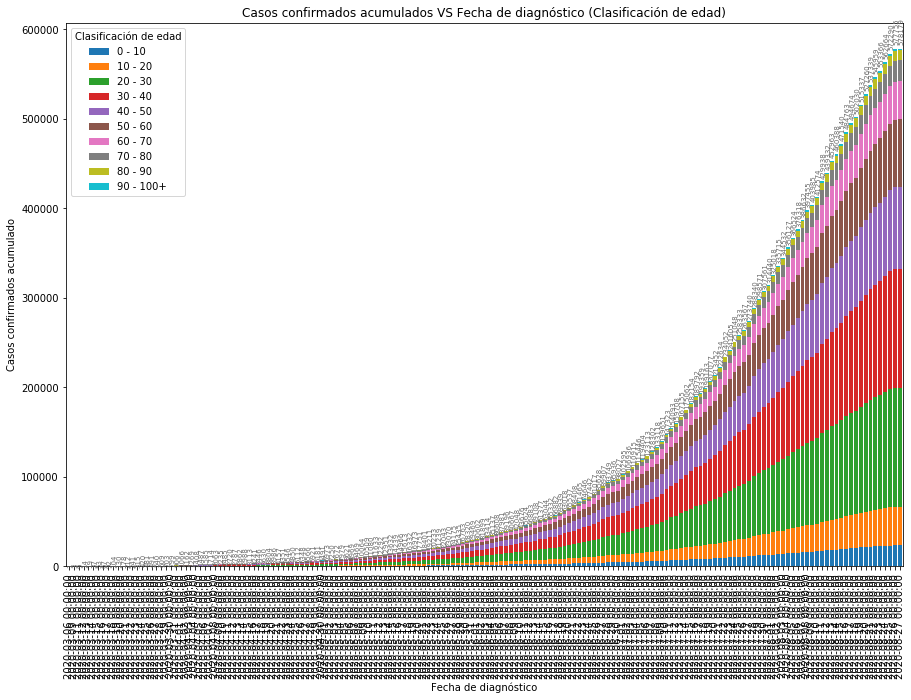

In [39]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [40]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-27              23412    43305   132905   132931    91512    74943   
2020-08-26              23395    43285   132799   132839    91448    74877   
2020-08-25              23200    42862   131628   131637    90617    74176   
2020-08-24              22858    42226   129450   129397    89051    72894   
2020-08-23              22507    41536   127291   127303    87596    71692   
2020-08-22              22205    40931   125509   125574    86498    70720   
2020-08-21              21896    40277   123527   123520    85199    69628   
2020-08-20              21486    39550   121131   121229    83605    68308   
2020-08-19              21021    38700   118513   118560    81715    66710   
2020-08-18              20400    37723   115520   115582    79536    65025   
2020-08-17              20158    37213   113898   113923    78356    64018   
2020-08-16              19657    36452   111696   111839    76775    62693   
2020-08-15              19050    35312   108755   108955    74672    60958   
2020-08-14              18567    34470   106201   106488    72923    59456   
2020-08-13              18318    33935   104501   104840    71728    58411   
2020-08-12              17712    32865   101419   101751    69553    56614   
2020-08-11              17377    32232    99362    99588    68062    55363   
2020-08-10              16599    30974    95265    95565    65239    53123   
2020-08-09              16283    30285    93323    93573    63895    52012   
2020-08-08              16042    29862    91819    92149    62815    51132   
2020-08-07              15633    29074    89379    89509    61111    49712   
2020-08-06              15229    28297    87016    87076    59473    48377   
2020-08-05              14782    27552    84837    84841    57905    47104   
2020-08-04              14368    26818    82450    82434    56219    45740   
2020-08-03              13885    25996    79790    79724    54317    44156   
2020-08-02              13564    25385    77792    77674    52971    42938   
2020-08-01              13129    24659    75379    75279    51164    41437   
2020-07-31              12721    23801    72824    72770    49543    40094   
2020-07-30              12458    23337    71291    71133    48368    39245   
2020-07-29              12132    22610    69105    69001    47042    38071   
2020-07-28              11755    21860    66681    66527    45356    36826   
2020-07-27              11136    20716    63353    63239    43039    34893   
2020-07-26              10757    19989    60964    60856    41369    33680   
2020-07-25              10549    19663    59773    59629    40555    32999   
2020-07-24              10272    19174    58134    57925    39388    32009   
2020-07-23               9954    18450    55929    55636    37911    30775   
2020-07-22               9681    17931    54244    53888    36710    29785   
2020-07-21               9286    17079    51517    51298    34924    28240   
2020-07-20               8930    16449    49352    49117    33441    27088   
2020-07-19               8656    15986    47996    47657    32371    26259   
2020-07-18               8348    15323    46160    45801    31060    25277   
2020-07-17               8131    14979    44863    44385    30103    24525   
2020-07-16               8009    14759    44061    43524    29556    24071   
2020-07-15               7675    14241    42347    41712    28303    23049   
2020-07-14               7385    13701    40738    40098    27172    22115   
2020-07-13               7094    13112    38870    38219    25895    21139   
2020-07-12               6843    12620    37086    36504    24681    20151   
2020-07-11               6605    12192    35775    35231    23767    19409   
2020-07-10               6362    11737    34143    33600    22682    18552   
2020-07-09            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

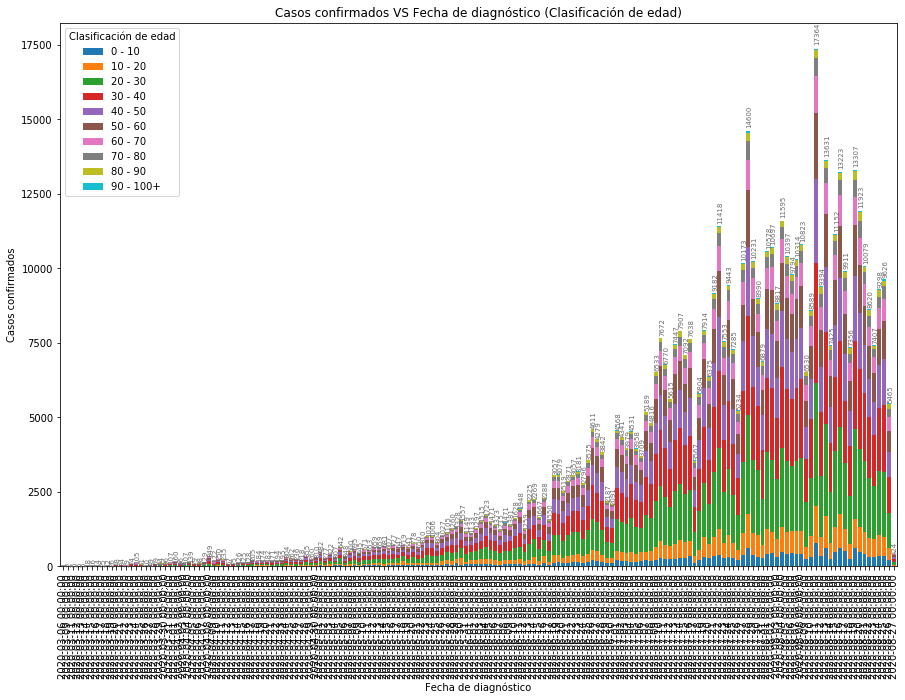

In [41]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [42]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-27                 17       20      106       92       64       66   
2020-08-26                195      423     1171     1202      831      701   
2020-08-25                342      636     2178     2240     1566     1282   
2020-08-24                351      690     2159     2094     1455     1202   
2020-08-23                302      605     1782     1729     1098      972   
2020-08-22                309      654     1982     2054     1299     1092   
2020-08-21                410      727     2396     2291     1594     1320   
2020-08-20                465      850     2618     2669     1890     1598   
2020-08-19                621      977     2993     2978     2179     1685   
2020-08-18                242      510     1622     1659     1180     1007   
2020-08-17                501      761     2202     2084     1581     1325   
2020-08-16                607     1140     2941     2884     2103     1735   
2020-08-15                483      842     2554     2467     1749     1502   
2020-08-14                249      535     1700     1648     1195     1045   
2020-08-13                606     1070     3082     3089     2175     1797   
2020-08-12                335      633     2057     2163     1491     1251   
2020-08-11                778     1258     4097     4023     2823     2240   
2020-08-10                316      689     1942     1992     1344     1111   
2020-08-09                241      423     1504     1424     1080      880   
2020-08-08                409      788     2440     2640     1704     1420   
2020-08-07                404      777     2363     2433     1638     1335   
2020-08-06                447      745     2179     2235     1568     1273   
2020-08-05                414      734     2387     2407     1686     1364   
2020-08-04                483      822     2660     2710     1902     1584   
2020-08-03                321      611     1998     2050     1346     1218   
2020-08-02                435      726     2413     2395     1807     1501   
2020-08-01                408      858     2555     2509     1621     1343   
2020-07-31                263      464     1533     1637     1175      849   
2020-07-30                326      727     2186     2132     1326     1174   
2020-07-29                377      750     2424     2474     1686     1245   
2020-07-28                619     1144     3328     3288     2317     1933   
2020-07-27                379      727     2389     2383     1670     1213   
2020-07-26                208      326     1191     1227      814      681   
2020-07-25                277      489     1639     1704     1167      990   
2020-07-24                318      724     2205     2289     1477     1234   
2020-07-23                273      519     1685     1748     1201      990   
2020-07-22                395      852     2727     2590     1786     1545   
2020-07-21                356      630     2165     2181     1483     1152   
2020-07-20                274      463     1356     1460     1070      829   
2020-07-19                308      663     1836     1856     1311      982   
2020-07-18                217      344     1297     1416      957      752   
2020-07-17                122      220      802      861      547      454   
2020-07-16                334      518     1714     1812     1253     1022   
2020-07-15                290      540     1609     1614     1131      934   
2020-07-14                291      589     1868     1879     1277      976   
2020-07-13                251      492     1784     1715     1214      988   
2020-07-12                238      428     1311     1273      914      742   
2020-07-11                243      455     1632     1631     1085      857   
2020-07-10                282      554     1855     1883     1158      988   
2020-07-09            

### - Casos confirmados VS Estado (Clasificación de edad)

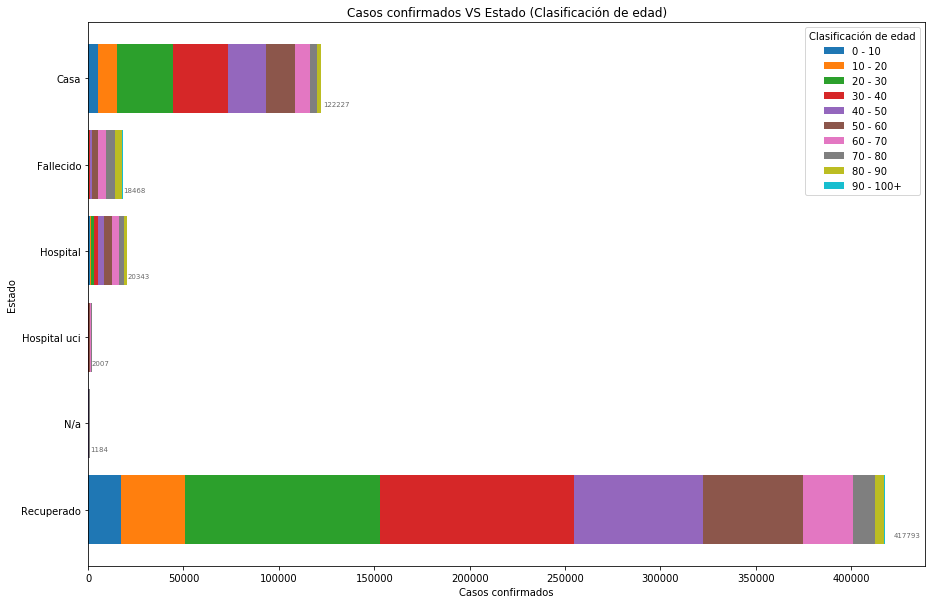

In [43]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [44]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     5202     9702    29499    28935    19768    15481   
Fallecido                  29       32      237      604     1348     2795   
Hospital                  803      495     1687     2429     2905     4145   
Hospital uci               41       35       90      196      297      495   
N/a                        28       20       53       43       91      143   
Recuperado              17440    33300   102251   101651    67668    52355   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      7896     3761     1669        314  
Fallecido                 4469     4692     3472        790  
Hospital                  3844     2605     1236        194  
Hospital uci               469      299       77          8  
N/a                        241      273      233         59  
Recuperado               26049    11746     4590        743

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

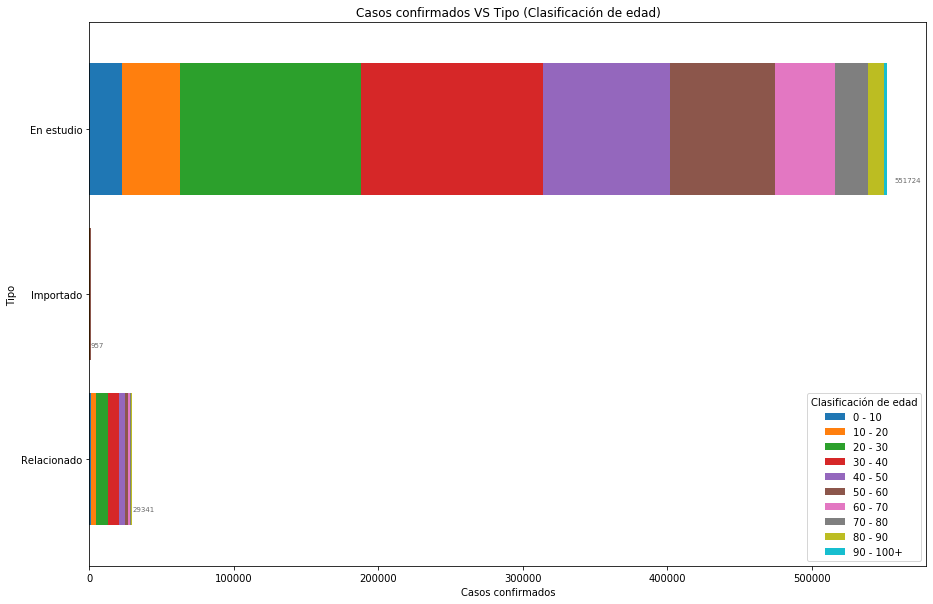

In [45]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [46]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              22563    39806   125249   126025    88163    72714   
Importado                   5       37      239      222      169      144   
Relacionado               975     3741     8329     7611     3745     2556   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               41556    22747    10888       2013  
Importado                   95       36        9          1  
Relacionado               1317      593      380         94

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>